## Spectral Clustering(标准实现)

d:\Users\epiph\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


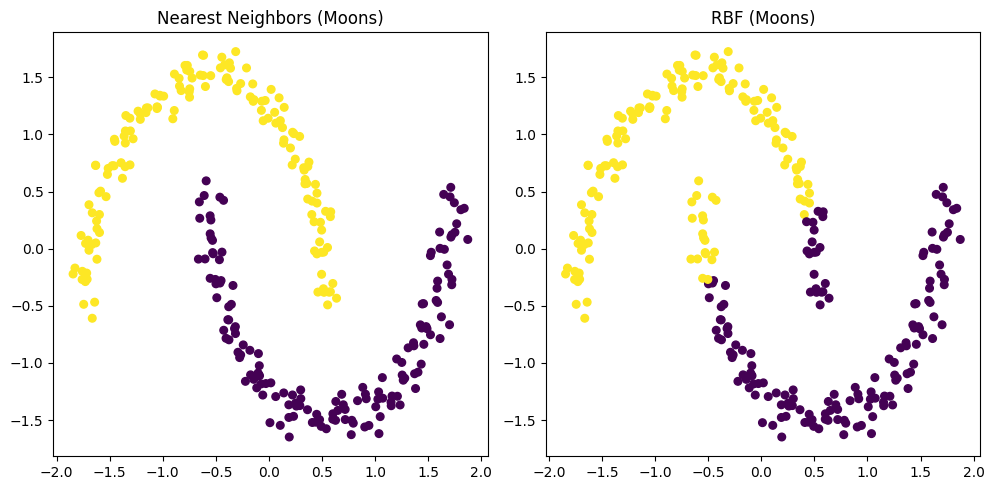

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler

# Generate synthetic datasets
X_moons, _ = make_moons(n_samples=300, noise=0.05, random_state=42)
X_circles, _ = make_circles(n_samples=300, factor=0.5, noise=0.05, random_state=42)

# Standardize the circles dataset for cosine affinity
scaler = StandardScaler()
X_moons = scaler.fit_transform(X_moons)

# Spectral Clustering models with different affinities
models = {
    "nearest_neighbors (Moons)": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42),
    "rbf (Moons)": SpectralClustering(n_clusters=2, affinity='rbf', gamma=1.0, random_state=42),
    # "cosine (Circles)": SpectralClustering(n_clusters=2, affinity='cosine', random_state=42)
}

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Moons dataset with nearest_neighbors
y_pred = models["nearest_neighbors (Moons)"].fit_predict(X_moons)
axes[0].scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred, cmap='viridis', s=30)
axes[0].set_title("Nearest Neighbors (Moons)")

# Moons dataset with rbf
y_pred = models["rbf (Moons)"].fit_predict(X_moons)
axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_pred, cmap='viridis', s=30)
axes[1].set_title("RBF (Moons)")

# Circles dataset with cosine
# y_pred = models["cosine (Circles)"].fit_predict(X_moons)
# axes[2].scatter(X_circles[:, 0], X_circles[:, 1], c=y_pred, cmap='viridis', s=30)
# axes[2].set_title("Cosine (Circles)")

plt.tight_layout()
plt.show()


## Normalized Cut
Normalized Cut 是谱聚类的经典变种，目标是最小化子图之间的关联度（边权重）。

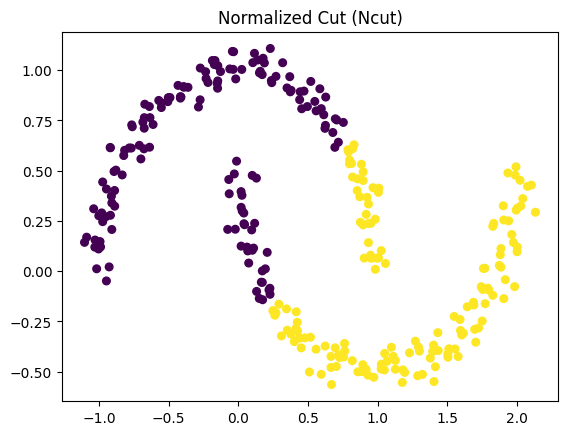

In [12]:
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate synthetic data
X, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

# Compute affinity matrix (RBF kernel)
def rbf_kernel(X, gamma=1.0):
    pairwise_sq_dists = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2 * np.dot(X, X.T)
    return np.exp(-gamma * pairwise_sq_dists)

affinity_matrix = rbf_kernel(X, gamma=1.0)

# Compute normalized Laplacian
laplacian_matrix = laplacian(affinity_matrix, normed=True)

# Compute eigenvectors
eigvals, eigvecs = eig(laplacian_matrix)
eigvecs = eigvecs[:, np.argsort(eigvals)[:2]]  # Select first 2 eigenvectors

# Use K-Means to cluster on eigenvectors
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(eigvecs)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Normalized Cut (Ncut)")
plt.show()


## Ratio Cut
Ratio Cut 是一种基于图划分的变种，目标是最小化子图之间边权重占节点数的比例。与 Ncut 类似，但没有归一化处理。

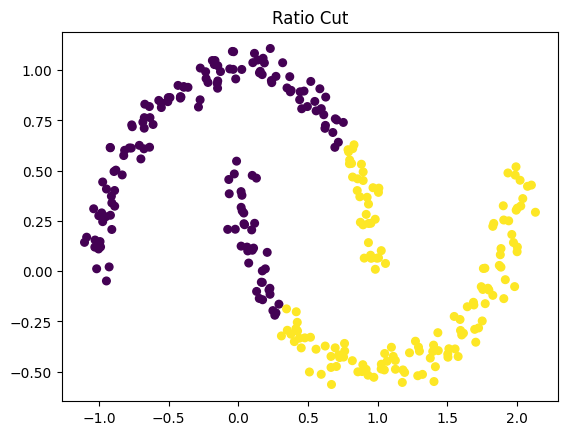

In [13]:
# Compute unnormalized Laplacian
laplacian_matrix = laplacian(affinity_matrix, normed=False)

# Compute eigenvectors
eigvals, eigvecs = eig(laplacian_matrix)
eigvecs = eigvecs[:, np.argsort(eigvals)[:2]]  # Select first 2 eigenvectors

# Use K-Means to cluster on eigenvectors
labels = kmeans.fit_predict(eigvecs)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Ratio Cut")
plt.show()


## Multilevel Spectral Clustering
Multilevel Spectral Clustering 通过递归方法减少特征分解的计算复杂度。这种方法通常需要自定义实现，这里用递归方式模拟。

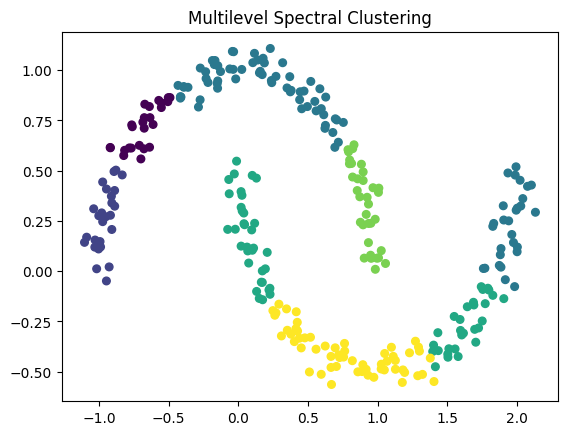

In [14]:
def multilevel_spectral_clustering(X, num_clusters, levels=2):
    if levels == 0:
        return KMeans(n_clusters=num_clusters).fit_predict(X)
    
    # Perform spectral clustering at current level
    affinity_matrix = rbf_kernel(X, gamma=1.0)
    laplacian_matrix = laplacian(affinity_matrix, normed=True)
    eigvals, eigvecs = eig(laplacian_matrix)
    eigvecs = eigvecs[:, np.argsort(eigvals)[:num_clusters]]
    
    # Cluster and recurse
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(eigvecs)
    
    # Recursive clustering on each cluster
    final_labels = np.zeros_like(labels)
    for cluster_id in np.unique(labels):
        cluster_points = X[labels == cluster_id]
        sub_labels = multilevel_spectral_clustering(cluster_points, num_clusters, levels - 1)
        final_labels[labels == cluster_id] = sub_labels + cluster_id * num_clusters
    
    return final_labels

# Apply multilevel spectral clustering
labels = multilevel_spectral_clustering(X, num_clusters=2, levels=2)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Multilevel Spectral Clustering")
plt.show()


## Eigengap Heuristic
在谱聚类中，eigengap 是用于选择簇数的指标。下面展示自动选择簇数的代码：

Optimal number of clusters: 2


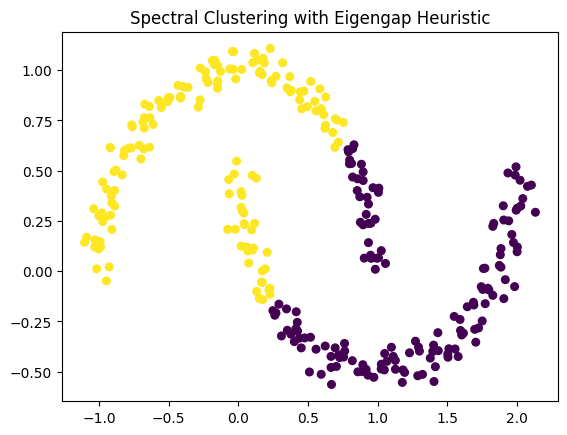

In [15]:
from sklearn.cluster import SpectralClustering

def eigengap_heuristic(X, max_clusters=10):
    affinity_matrix = rbf_kernel(X, gamma=1.0)
    laplacian_matrix = laplacian(affinity_matrix, normed=True)
    eigvals, _ = eig(laplacian_matrix)
    eigvals = np.sort(eigvals)
    eigengap = np.diff(eigvals[:max_clusters])
    best_k = np.argmax(eigengap) + 1
    return best_k

# Determine optimal number of clusters
best_k = eigengap_heuristic(X, max_clusters=5)
print(f"Optimal number of clusters: {best_k}")

# Perform spectral clustering with optimal clusters
model = SpectralClustering(n_clusters=best_k, affinity='rbf', gamma=1.0, random_state=42)
labels = model.fit_predict(X)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30)
plt.title("Spectral Clustering with Eigengap Heuristic")
plt.show()


以下是关于谱聚类及其变种的总结分析，包括 **介绍**、**适用场景**、**优缺点**。

---

### **1. Spectral Clustering（标准谱聚类）**
#### **介绍**
- 标准谱聚类通过构造图的相似性矩阵，并使用图的拉普拉斯矩阵的特征值分解来找到低维嵌入，然后在低维空间中应用 K-Means 聚类。
- `SpectralClustering` 是 Scikit-learn 提供的标准实现。

#### **适用场景**
- 数据分布复杂，簇的形状为非线性。
- 数据点的相似性可以通过图的邻接矩阵表示。
- 需要捕捉数据的全局结构。

#### **优缺点**
| **优点**                                | **缺点**                                |
|-----------------------------------------|-----------------------------------------|
| 能处理非线性结构数据                     | 对相似性矩阵的计算较敏感               |
| 不依赖欧几里得距离                      | 计算复杂度较高，难以扩展到大规模数据   |
| 理论基础严谨，结果通常较稳定             | 需要选择合适的相似性度量和参数（如邻域大小、gamma） |

---

### **2. Normalized Cut（Ncut）**
#### **介绍**
- Normalized Cut 是谱聚类的经典变种，目标是最小化子图之间的边权重和，同时归一化簇的大小以避免不平衡。
- 通过特征分解最小化以下目标函数：
  \[
  \text{Ncut}(A, B) = \frac{\text{Cut}(A, B)}{\text{Assoc}(A, V)} + \frac{\text{Cut}(A, B)}{\text{Assoc}(B, V)}
  \]

#### **适用场景**
- 数据簇大小不均衡，或者需要避免小簇占比过低的情况。
- 图结构明确且可以通过归一化提高分割效果。

#### **优缺点**
| **优点**                                | **缺点**                                |
|-----------------------------------------|-----------------------------------------|
| 更适合不平衡数据                        | 计算复杂度较高                         |
| 结果更加鲁棒，减少过度分割的情况         | 对参数和相似性度量敏感                 |

---

### **3. Ratio Cut**
#### **介绍**
- Ratio Cut 目标是最小化子图之间边权重占子图大小的比例：
  \[
  \text{RatioCut}(A, B) = \frac{\text{Cut}(A, B)}{|A|} + \frac{\text{Cut}(A, B)}{|B|}
  \]
- 与 Ncut 类似，但不进行归一化。

#### **适用场景**
- 数据分布相对均匀，无需特别关注小簇的比例。

#### **优缺点**
| **优点**                                | **缺点**                                |
|-----------------------------------------|-----------------------------------------|
| 算法较简单，适合均匀数据                | 对不平衡簇的情况表现较差               |
| 计算复杂度较低                          | 缺乏归一化，可能导致不合理的分割        |

---

### **4. Multilevel Spectral Clustering**
#### **介绍**
- 通过递归优化减少特征分解的计算复杂度，适合大规模数据。
- 在每一级递归中，将数据分为子集，并对子集分别应用谱聚类。

#### **适用场景**
- 大规模数据的聚类。
- 数据具有层次性或递归分割的特性。

#### **优缺点**
| **优点**                                | **缺点**                                |
|-----------------------------------------|-----------------------------------------|
| 计算效率更高，适合大规模数据             | 实现较复杂，结果依赖递归策略            |
| 能处理层次关系                          | 参数和递归深度需要调优                 |

---

### **5. Eigengap Heuristic**
#### **介绍**
- `Eigengap` 是谱聚类中特征值排序中显著间隙的指标，用于自动选择最优簇数。
- 特征值排序中最大的间隙位置即为最佳簇数。

#### **适用场景**
- 数据分布复杂，不确定簇数。
- 自动化聚类任务。

#### **优缺点**
| **优点**                                | **缺点**                                |
|-----------------------------------------|-----------------------------------------|
| 自动选择簇数，减少手动干预               | 仅适用于谱聚类                         |
| 理论基础明确，适用多种数据               | 对数据特性依赖较高                     |

---

### **总结对比表**

| **方法**               | **特点**                                 | **适用场景**                          | **优点**                                    | **缺点**                                     |
|------------------------|------------------------------------------|---------------------------------------|---------------------------------------------|---------------------------------------------|
| **Spectral Clustering** | 标准谱聚类，基于拉普拉斯矩阵特征分解     | 非线性簇，复杂数据                    | 理论基础强，支持复杂结构                   | 参数敏感，计算复杂度高                      |
| **Normalized Cut**      | 归一化的图切割，避免不平衡               | 不平衡数据分布                        | 适合不平衡簇，减少过度分割                 | 计算复杂度高                                |
| **Ratio Cut**           | 简单的图切割，不进行归一化               | 数据分布均匀                          | 算法简单，计算快                           | 不适合不平衡簇                              |
| **Multilevel Spectral** | 递归分割，减少特征分解复杂度             | 大规模数据，层次性数据                | 支持大规模数据，处理层次关系               | 实现复杂，依赖递归策略                      |
| **Eigengap Heuristic**  | 自动选择最优簇数                         | 簇数未知，复杂数据                    | 自动化簇数选择，减少手动干预               | 仅适用于谱聚类                              |

---

### **选型建议**
- **数据分布复杂（非线性）**：使用标准 **Spectral Clustering**。
- **数据簇大小不均衡**：选择 **Normalized Cut**。
- **大规模数据，效率需求高**：使用 **Multilevel Spectral Clustering**。
- **簇数未知**：结合 **Eigengap Heuristic** 自动确定簇数。

如需进一步扩展或调整，请随时告诉我！

### **`nearest_neighbors` 和 `rbf` 的区别**

在 **Spectral Clustering** 中，`affinity` 参数决定了如何构造相似性矩阵（Affinity Matrix）。两种常用的相似性构造方式是 `nearest_neighbors` 和 `rbf`，它们各自的原理和适用场景有所不同。

---

### **1. nearest_neighbors**
#### **原理**
- 基于 **最近邻图** (K-Nearest Neighbors Graph) 构造相似性矩阵：
  - 每个点仅与其最近的 `n_neighbors` 个点相连，其他点之间的相似性为 0。
  - 形成的相似性矩阵是稀疏矩阵，适合稀疏数据。

#### **特点**
- 强调局部相似性：仅考虑点的最近邻，忽略远距离点。
- 相似性矩阵更加稀疏，有助于降低计算复杂度。
- 参数：
  - **`n_neighbors`**：决定每个点的连接范围。
  - 越大表示连接的点越多，越小则强调更局部的连接。

#### **适用场景**
- 数据的局部结构较为重要，且簇形状复杂或边界模糊。
- 数据点之间的全局关系不明显，或者需要降低计算复杂度时。

#### **优缺点**
| **优点**                          | **缺点**                          |
|-----------------------------------|-----------------------------------|
| 构造稀疏矩阵，计算复杂度较低       | 参数 `n_neighbors` 需要调试       |
| 更适合局部结构复杂的非线性数据     | 对远距离点可能缺乏全局连接信息    |

---

### **2. rbf**
#### **原理**
- 基于 **径向基核函数 (Radial Basis Function, RBF)** 计算相似性：
  - 两点之间的相似性由其欧几里得距离决定：
    \[
    s(i, j) = \exp(-\gamma \cdot ||x_i - x_j||^2)
    \]
  - `gamma` 控制相似性随距离衰减的速度。

#### **特点**
- 强调全局相似性：任意两点之间都会计算相似性（相似性矩阵是稠密矩阵）。
- 参数：
  - **`gamma`**：控制距离对相似性的影响。
    - 较大时，相似性集中在较近的点，远点几乎没有贡献。
    - 较小时，相似性分布较广，强调全局特性。

#### **适用场景**
- 数据具有全局相似性，或者簇之间的距离较大。
- 数据分布稠密，需要捕捉全局关系。

#### **优缺点**
| **优点**                          | **缺点**                          |
|-----------------------------------|-----------------------------------|
| 强调全局相似性，适合连续分布数据   | 相似性矩阵是稠密矩阵，计算开销大   |
| 参数 `gamma` 提供了灵活的调整机制   | 对参数 `gamma` 的选择非常敏感      |

---

### **3. 两者对比**

| **特性**               | **nearest_neighbors**                      | **rbf**                              |
|------------------------|--------------------------------------------|---------------------------------------|
| **相似性定义**         | 仅与最近的 `n_neighbors` 个点连接           | 任意两点之间都有相似性（全局相似性） |
| **矩阵类型**           | 稀疏矩阵                                  | 稠密矩阵                             |
| **参数**               | `n_neighbors`                             | `gamma`                              |
| **计算复杂度**         | 较低                                      | 较高                                 |
| **适用数据**           | 局部结构复杂或数据稀疏                    | 连续分布数据                         |
| **优点**               | 强调局部关系，适合非线性复杂数据           | 强调全局关系，适合连续性分布的数据   |
| **缺点**               | 可能忽略全局信息，对 `n_neighbors` 敏感     | 计算开销高，对 `gamma` 敏感          |

---

### **4. 应用实例对比**

#### **数据集：Moons**
对于 **Moons 数据集**，我们可以观察到以下差异：

1. **`nearest_neighbors`**
   - 能够更好地捕捉局部结构，如 Moons 的两个环状簇。
   - 对于边界模糊的点，可能会过于依赖局部连接。

2. **`rbf`**
   - 强调全局相似性，可能模糊局部复杂性。
   - 如果 `gamma` 设置不当，可能导致簇之间的分割不清晰。

以下是两种方法在 Moons 数据集上的可视化效果：

```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering

# Generate synthetic dataset
X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

# Models
nearest_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42, n_neighbors=10)
rbf_model = SpectralClustering(n_clusters=2, affinity='rbf', gamma=1.0, random_state=42)

# Fit and predict
nearest_labels = nearest_model.fit_predict(X)
rbf_labels = rbf_model.fit_predict(X)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X[:, 0], X[:, 1], c=nearest_labels, cmap='viridis', s=30)
axes[0].set_title("Nearest Neighbors (Moons)")

axes[1].scatter(X[:, 0], X[:, 1], c=rbf_labels, cmap='viridis', s=30)
axes[1].set_title("RBF (Moons)")

plt.tight_layout()
plt.show()
```

通过观察两者的聚类结果，`nearest_neighbors` 更适合捕捉局部关系，而 `rbf` 更适合强调全局相似性。
